# Lennard-Jones Molecular Dynamics <a name="top"></a>

Molecular dynamics (MD) can be used to describe the motion of particles. This can be done in different flavors, e.g., using ab initio methods like DFT, or using force fields. Force fields use a purely classical description that tries to mimic the behavior of the respective particles.
These force fields can have varying complexities. A typical energy term of a force field looks like this:
$$
E_\mathrm{total} = E_\mathrm{bonded} + E_\mathrm{nonbonded} = E_\mathrm{bond} + E_\mathrm{angle} + E_\mathrm{dihedral} + E_\mathrm{electrostatic} + E_\mathrm{vdW}.
$$

In this notebook, we will take a look at the simulation of argon atoms. Looking at the energy contributions, we find that for (neutral) noble gases only the van-der-Waals term remains non-zero.

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from viewer import view_traj

amu = sc.constants.value("atomic mass constant")
Boltzmann = sc.constants.Boltzmann
calorie = sc.constants.calorie
kcalmol = 1000 * calorie / sc.constants.value("Avogadro constant")

## Calculation parameters

One example of a rather simple force field is [OPLS](https://en.wikipedia.org/wiki/OPLS) (Optimized Potentials for Liquid Simulations).
Force fields need different parameters that can usually obtained from quantum mechanical simulations or experiments to ensure an accurate description of the system. Often, these parameterizations are system-specific and non-generalizable.
However, the parameterization of force fields is an art on its own.

Given are the parameters from OPLS-AA for argon. The parameters can be found [here](https://github.com/jewettaij/moltemplate/blob/master/moltemplate/force_fields/oplsaa.lt). Additionally, we set a simulation cell size. Here we initialize a cubic unit cell.

In [2]:
SIGMA = 3.401  # Potential energy at the equilibrium bond length (Å).
EPSILON = 0.2339  # Distance at which the potential energy is zero (kcal/mole).
MASS = 39.948  # Mass (grams/mole).
BOX_DIM = np.ones(3) * 20  # Simulation box (Å).

## Lennard-Jones potentials

The force can be calculated as the negative gradient of the potential energy: $f(r) = -\frac{\partial V(r)}{\partial r}$.
The following function calculates the force of a [Lennard-Jones (LJ) potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) (sometimes called a 12-6-potential) to describe van-der-Waals interactions.

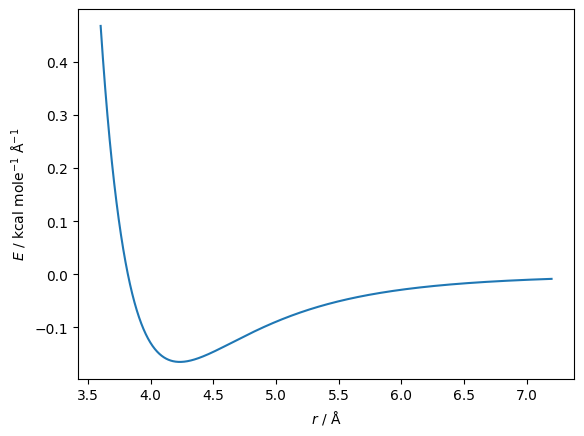

In [3]:
def lj_force(r):
    """Force of a Lennard-Jones potential.

    Args:
        r: Particle distance (Å).

    Returns:
        Force of the van-der-Waals interaction (kcal/mole Å).
    """
    return 48 * EPSILON * SIGMA**12 / r**13 - 24 * EPSILON * SIGMA**6 / r**7


r = np.linspace(3.6, 7.2, 1000)
plt.plot(r, lj_force(r))
plt.xlabel(r"$r$ / Å")
plt.ylabel(r"$E$ / kcal mole$^{-1}$ Å$^{-1}$")
plt.show()

## Velocity Verlet algorithm

To run our molecular dynamics simulation we have to update positions and velocities. This can be done using the Newtonian equations of motion. This implementation follows the [Velocity Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet).

Depending on the initial conditions, atoms can travel together in an MD simulation, or they will depart and never come together. In case we want to simulate a somewhat realistic system like a fluid, we have to extend the system size. But the problem of departing atoms will persist on the edges. We could make the system larger and larger, but limited computational resources forbid this. Instead, we can make use of periodic boundary conditions (PBCs). With them, we can simulate an infinite system by considering repetitions of our system. We can do this because of ergodicity, we just have to run our simulation for a longer time.

The position update function incorporates PBCs. This means, if one particle reaches the edge of the simulation cell, it will appear on the other side of the cell.

In [4]:
def update_vel(v, a0, a1, dt):
    """Update the particle velocities.

    Args:
        v: The velocities for all of the particles (kcal fs/Å g).
        a0: The accelerations for all of the particles at the previous timestep (kcal/Å g).
        a1: The accelerations for all of the particles at the current timestep (kcal/Å g).
        dt: The timestep length (fs).

    Returns:
        New velocities of the particles (kcal fs/Å g).
    """
    return v + 0.5 * (a0 + a1) * dt


def update_pos(x0, v, a, dt):
    """Update the particle positions accounting for the periodic boundary condition.

    Args:
        x0: The positions for all of the particles (Å).
        v: The velocities for all of the particles (kcal fs/Å g).
        a: The accelerations for all of the particles (kcal/Å g).
        dt: The timestep length (fs).

    Returns:
        New positions of the particles (Å).
    """
    x = x0 + v * dt + 0.5 * a * dt**2
    return x % BOX_DIM

## Accelerations

To calculate the motion of a particle we have to evaluate our system at different time steps and calculate the evolution. For this, we need the accelerations of particles at different times. The workflow for this is as follows:

* Calculate the unit vector $\mathbf r$ between particles with $\mathbf r = \frac{r}{|\mathbf r|}$.
* Calculate the LJ force between the particles.
* Evaluate the force component of each particle with $\mathbf f = f \mathbf r$.
* Calculate the accelaration using $\mathbf f = m \mathbf a$.
* The final acceleration of one particle is the sum of all contributions.

`a` contains the accelerations of each particle in relation to each particle. The matrix `a` is skew-symmetric ($A^T = -A$). The diagonal will contain zeros (no particle accelerates itself), and by Newton's 3rd law of motion, we get $f_{ij} = -f_{ji}$.

The following function calculates the accelerations as necessary. It gets a bit more complicated due to PBCs.

In [5]:
def get_accelerations(x):
    """Calculate the acceleration on each particle.

    Args:
        x: The positions for all of the particles (Å).

    Returns:
        The acceleration on each particle (kcal/Å g).
    """
    N = len(x)
    a = np.zeros((N, N, 3))
    for i in range(N - 1):
        r = x[i + 1 :] - x[i]
        dim = np.ones_like(r) * BOX_DIM
        mask = r > dim / 2
        if np.any(mask):  # If the mask is empty, do not try to calculate anything
            r[mask] = dim[mask] - r[mask]
        rm = np.linalg.norm(r, axis=1)
        f = (lj_force(rm) / rm)[:, None] * r
        a[i, i + 1 :, :] = f / MASS
        a[i + 1 :, i, :] = -a[i, i + 1 :, :]
    return np.sum(a, axis=0)

## Heat baths

When performing an MD calculation the temperature of the system may change over time, see
$$
\frac{1}{2} m v^2 = \frac{3}{2} k_B T.
$$

To mitigate this problem one can use so-called heat baths. They will simply rescale the velocities to achieve the desired temperature. The simplest form would be
$$
v_\mathrm{new} = v_\mathrm{old} \frac{T_\mathrm{desired}}{T}.
$$

Please note that this is no thermostat that is used in practice. Instead of rescaling the velocities such that a certain temperature is achieved, instead a desired temperature average should be achieved.

In [6]:
def get_temperature(v):
    """Calculate a temperature from given velocities.

    Args:
        v: Velocities (kcal fs/Å g).

    Returns:
        Current temperature (K).
    """
    vm = np.linalg.norm(v, axis=1)
    k = 0.5 * MASS * np.sum(vm**2)
    avg_k = k / len(vm)
    return (2 / 3) * avg_k * amu * calorie * 1e6 / Boltzmann


def heat_bath(v, T0):
    """Velocity rescaling.

    Args:
        v: Velocities (kcal fs/Å g).
        T0: Initial temperature (K).

    Returns:
        Rescaled velocities (kcal fs/Å g).
    """
    T = get_temperature(v)
    return v * T0 / T

## Maxwell-Boltzmann distributions

To initialize a dynamic system we have to give each particle an initial velocity. This can be done using probability distribution functions like the [Maxwell-Boltzmann distribution](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution).

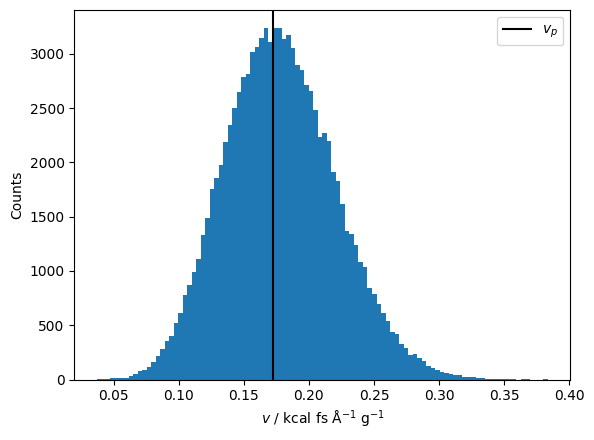

In [7]:
def init_velocity(T, N):
    """Maxwell-Boltzmann velocity distribution.

    Args:
        T: Temperature of the system at initialization (K).
        N: Number of particles in the system.

    Returns:
        Initial velocities (kcal fs/Å g).
    """
    sign = np.random.choice([-1, 1], size=(N, 3))  # Select a random sign for the velocity contribution
    return sign * np.array([sc.stats.maxwell.rvs(size=N, scale=np.sqrt(Boltzmann * T / MASS / kcalmol))for i in range(3)]).T/ 2


T = 300
v = np.linalg.norm(init_velocity(T, 100000), axis=1)
plt.hist(v, bins=100)
plt.axvline(np.sqrt(2 * Boltzmann * T / MASS / kcalmol), c="k", label="$v_p$")  # Most probable speed
plt.xlabel("$v$ / kcal fs Å$^{-1}$ g$^{-1}$")
plt.ylabel("Counts")
plt.legend()
plt.show()

## File writing

To have a nice visualization of the resulting trajectories we want to write the atom positions in each time step to a file.
See the XYZ format description [here](https://open-babel.readthedocs.io/en/latest/FileFormats/XYZ_cartesian_coordinates_format.html).

In [8]:
def write_xyz(filename, pos):
    """Write XYZ files.

    Args:
        pos: Atom positions.
        fp: File pointer.
    """
    with open(filename, "a") as fp:
        fp.write(f"{len(pos)}\n\n")
        for ia in range(len(pos)):
            fp.write(f'{"Ar":<2s}  {pos[ia, 0]: .6f}  {pos[ia, 1]: .6f}  {pos[ia, 2]: .6f}\n')

## Molecular dynamics

Almost done! At last, we have to tie everything together.

The general workflow for the simulation is as follows:
* Initialize the positions.
* Initialize the velocities.
* Calculate the initial accelerations.
* For the number of time steps:
  1. Update the particle positions.
  2. Calculate the new accelerations.
  3. Update the particle velocities.
  4. Rescale the velocities.
  5. Write the trajectory.

In [9]:
def run_md(dt, Nt, N, T):
    """Run a MD simulation.

    Args:
        dt: The timestep length (fs).
        Nt: Number of time steps.
        N: Number of particles.
        T: Temperature of the system at initialization (K).
    """
    pathlib.Path("md.traj").unlink(missing_ok=True)  # Remove the trajectory file before every MD run
    x = np.random.default_rng().random((N, 3)) * BOX_DIM  # Use random particle positions
    v = init_velocity(T, N)
    a0 = get_accelerations(x)
    for i in range(Nt):
        x = update_pos(x, v, a0, dt)
        a1 = get_accelerations(x)
        v = update_vel(v, a0, a1, dt)
        v = heat_bath(v, T)
        a0 = np.array(a1)
        if i % 10 == 0:  # Only write every 10th time step
            write_xyz("md.traj", x)
    return view_traj("md.traj", BOX_DIM)


run_md(1, 10000, 13, 10)

NGLWidget(max_frame=999)

<img src="lj_md.gif" alt="drawing" width="450"/>

## Lennard-Jones cluster

With the right parameters (e.g. a small enough temperature, like the ones given above) the argon atoms (or other noble gases) will form clusters. These are the so-called LJ clusters. We can nicely see them when running this notebook. For reference, visualizations of some LJ clusters are given in Fig. 1.

<img src="lj_clusters.jpg" alt="drawing" width="450"/>

__Figure 1__: Global minima of Lennard-Jones clusters of up to 20 atoms (Procedia Comput. Sci. 51, 1878 (2015)).

---
* [Back to top](#top)
<div style="text-align: right"><a href="https://gitlab.com/wangenau/lj_dynamics">Source code</a></div>
<div style="text-align: right"><span style="color:darkgray">© 2024 Wanja Schulze</span></div>